## Week 9 Notebook

For this week, include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization. This homework should be submitted for peer review in the assignment titled 9.3 Peer Review: Week 9 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.ensemble import GradientBoostingClassifier

# data preprocesing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score

random_state = 0

In [2]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
# Create a function to load and split data
def split_data(df: pd.DataFrame, target=None, test_size=0.2, random_state=random_state, choice='norm'):

    # Feature and target
    X = df.drop(columns=target)
    y = df[target]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    # reshaye y to 1D array
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Normalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

In [4]:
# Load the cleaned datasets
df_ins = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv')
df_car = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv')

In [5]:
# Encode the datasets
df_ins_encoded = encoding(df_ins, one_hot=False)
df_ins_oh = encoding(df_ins, one_hot=True)

df_car_encoded = encoding(df_car, one_hot=False)
df_car_oh = encoding(df_car, one_hot=True)

In [6]:
# Regularized data
X_train_car_reg, X_test_car_reg, y_train_car_reg, y_test_car_reg, df_car_reg = split_data(df_car_encoded, target='FraudFound', choice='reg')
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = split_data(df_ins_encoded, target='fraud_reported', choice='reg')

# Regularized One-hot data
X_train_car_oh_reg, X_test_car_oh_reg, y_train_car_oh_reg, y_test_car_oh_reg, df_car_oh_reg = split_data(df_car_oh, target='FraudFound', choice='reg')
X_train_ins_oh_reg, X_test_ins_oh_reg, y_train_ins_oh_reg, y_test_ins_oh_reg, df_ins_oh_reg = split_data(df_ins_oh, target='fraud_reported', choice='reg')

In [7]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state, scoring='recall', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [8]:
def classifier_model(data_used, model_class, X_train, y_train, X_test, y_test, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        data_used: String indicating the dataset used (for logging purposes).
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
        results: Dictionary of results for later analysis.
    """
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {clf_name} with {data_used}:")
    print(classification_report(y_test, y_pred, output_dict=False))
    print("\n")

    # Calculate accuracy, f1, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    print(f"{clf_name} F1 score: {f1:.2f}")
    print(f"{clf_name} Precision: {precision:.2f}")
    print(f"{clf_name} Recall: {recall:.2f}")
    
    # Calculate ROC-AUC if binary classification
    if len(model.classes_) == 2:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"{clf_name} ROC-AUC: {roc_auc:.2f}")

    # Plot the ROC curve
    if len(model.classes_) == 2:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {clf_name} with {data_used}')
        plt.legend(loc="lower right")
        plt.show()

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name} with {data_used}')
    plt.tight_layout()
    plt.show()

    # Save results for later analysis
    results = {
        'data_used': data_used,
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': roc_auc if len(model.classes_) == 2 else None
    }

    return model, y_pred, results

## Insurance Claims

In [9]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_oh_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_ins_oh, grid_cv_score_ins_oh = gridsearchcv(GradientBoostingClassifier,
                                                             X_train_ins_oh_reg,
                                                             y_train_ins_oh_reg,
                                                             param_dict=ins_oh_param_grid,
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          0.05         11           100       0.611282      0.035450               1.0              0.0
          0.01         11           400       0.611154      0.066017               1.0              0.0
          0.01         11           300       0.611154      0.066017               1.0              0.0
          0.01         11           500       0.606154      0.059748               1.0              0.0
          0.01          9           500       0.606154      0.028404               1.0              0.0

Best Parameters: {'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 100}
Best CV Score: 0.6113


In [10]:
# Run Gridsearch on the insurance claims dataset with one-hot encoding
ins_reg_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_ins_reg, grid_cv_score_ins_reg = gridsearchcv(GradientBoostingClassifier,
                                                             X_train_ins_reg,
                                                             y_train_ins_reg,
                                                             param_dict=ins_reg_param_grid,
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
           0.2          7           100       0.696538      0.072018               1.0              0.0
           0.1          7           400       0.686538      0.073753               1.0              0.0
           0.2          7           400       0.686410      0.063823               1.0              0.0
           0.2          7           200       0.686410      0.063823               1.0              0.0
           0.2          7           300       0.686410      0.063823               1.0              0.0

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Best CV Score: 0.6965


Classification Report for GradientBoostingClassifier with one-hot encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       151
           1       0.62      0.65      0.63        49

    accuracy                           0.81       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.82      0.81      0.82       200



GradientBoostingClassifier Accuracy: 0.81
GradientBoostingClassifier F1 score: 0.82
GradientBoostingClassifier Precision: 0.82
GradientBoostingClassifier Recall: 0.81
GradientBoostingClassifier ROC-AUC: 0.89


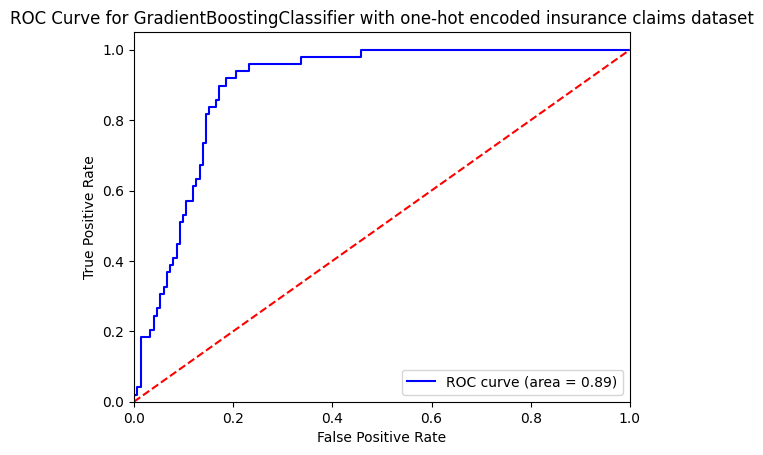

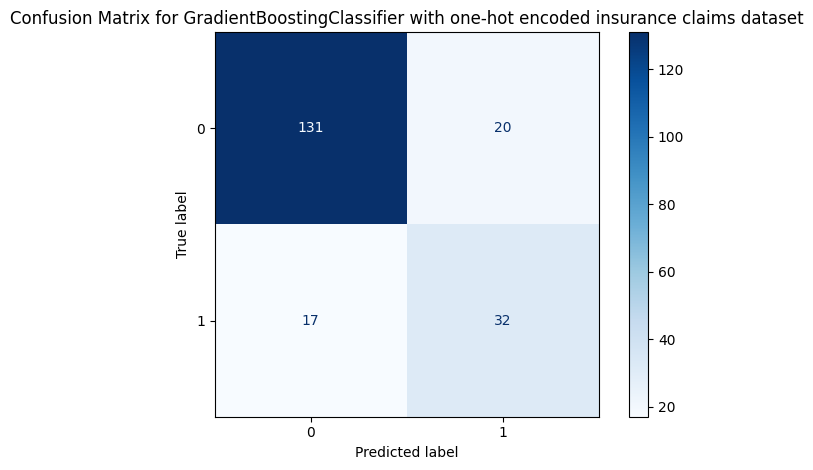

Classification Report for GradientBoostingClassifier with encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       151
           1       0.56      0.59      0.57        49

    accuracy                           0.79       200
   macro avg       0.71      0.72      0.72       200
weighted avg       0.79      0.79      0.79       200



GradientBoostingClassifier Accuracy: 0.79
GradientBoostingClassifier F1 score: 0.79
GradientBoostingClassifier Precision: 0.79
GradientBoostingClassifier Recall: 0.79
GradientBoostingClassifier ROC-AUC: 0.86


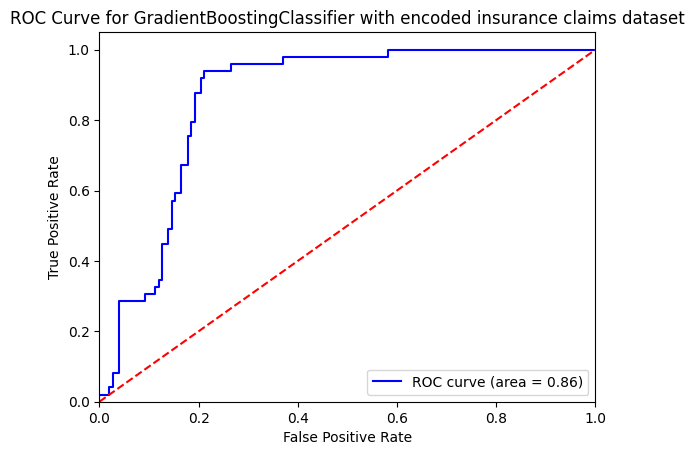

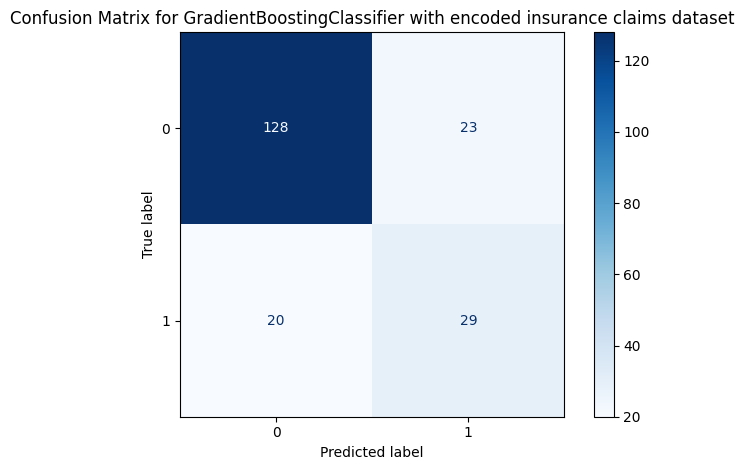

Classification Report for GradientBoostingClassifier with one-hot encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       151
           1       0.54      0.61      0.57        49

    accuracy                           0.78       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.79      0.78      0.78       200



GradientBoostingClassifier Accuracy: 0.78
GradientBoostingClassifier F1 score: 0.78
GradientBoostingClassifier Precision: 0.79
GradientBoostingClassifier Recall: 0.78
GradientBoostingClassifier ROC-AUC: 0.84


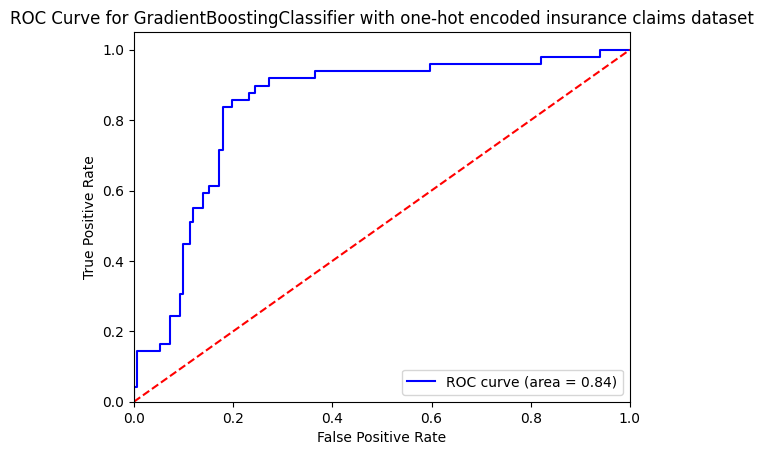

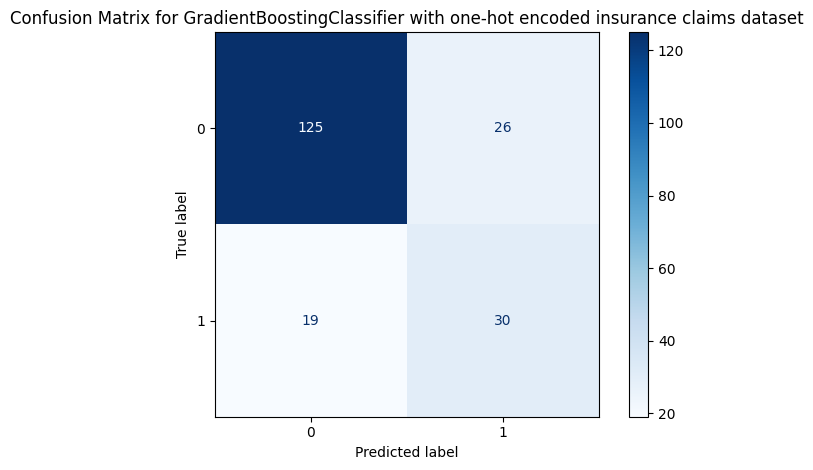

Classification Report for GradientBoostingClassifier with encoded insurance claims dataset:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       151
           1       0.57      0.67      0.62        49

    accuracy                           0.80       200
   macro avg       0.73      0.75      0.74       200
weighted avg       0.81      0.80      0.80       200



GradientBoostingClassifier Accuracy: 0.80
GradientBoostingClassifier F1 score: 0.80
GradientBoostingClassifier Precision: 0.81
GradientBoostingClassifier Recall: 0.80
GradientBoostingClassifier ROC-AUC: 0.87


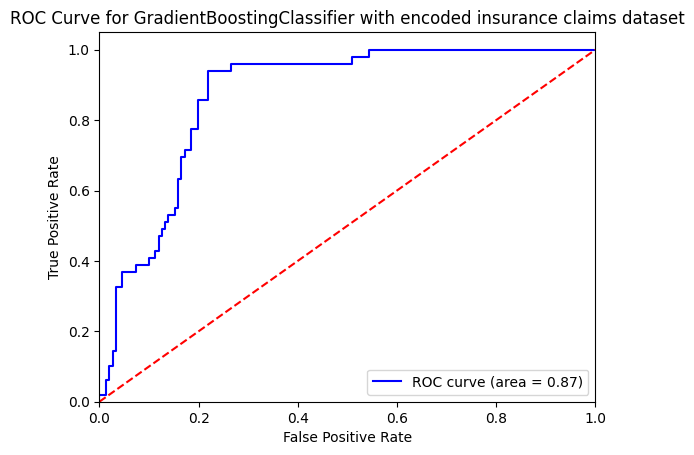

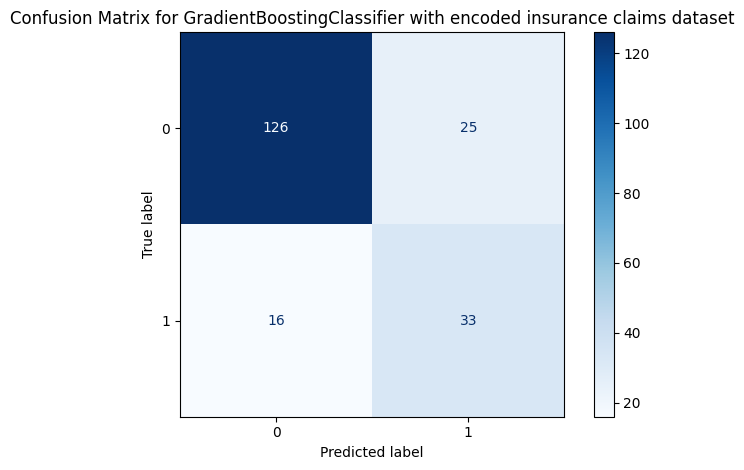

In [11]:
# Run a baseline version of Gradient Boosting on the insurance claims dataset with one-hot encoding and without
base_ins_oh_model, base_ins_oh_pred, base_ins_oh_results = classifier_model(
    "one-hot encoded insurance claims dataset",
    GradientBoostingClassifier,
    X_train_ins_oh_reg,
    y_train_ins_oh_reg,
    X_test_ins_oh_reg,
    y_test_ins_oh_reg
)

base_ins_reg_model, base_ins_reg_pred, base_ins_reg_results = classifier_model(
    "encoded insurance claims dataset",
    GradientBoostingClassifier, 
    X_train_ins_reg, 
    y_train_ins_reg, 
    X_test_ins_reg, 
    y_test_ins_reg
)

grid_ins_oh_model, grid_ins_oh_pred, grid_ins_oh_results = classifier_model(
    "one-hot encoded insurance claims dataset",
    GradientBoostingClassifier,
    X_train_ins_oh_reg,
    y_train_ins_oh_reg,
    X_test_ins_oh_reg,
    y_test_ins_oh_reg,
    **grid_best_params_ins_oh
)

grid_ins_reg_model, grid_ins_reg_pred, grid_ins_reg_results = classifier_model(
    "encoded insurance claims dataset",
    GradientBoostingClassifier, 
    X_train_ins_reg, 
    y_train_ins_reg, 
    X_test_ins_reg, 
    y_test_ins_reg,
    **grid_best_params_ins_reg
)


In [12]:
# DataFrame of the Insurance Claims results
df_ins_results = pd.DataFrame({
    'base_oh': base_ins_oh_results,
    'base_reg': base_ins_reg_results,
    'grid_oh': grid_ins_oh_results,
    'grid_reg': grid_ins_reg_results
})

# Print the results DataFrame
print("\nInsurance Claims Results DataFrame:\n")
df_ins_results


Insurance Claims Results DataFrame:



,base_oh,base_reg,grid_oh,grid_reg
data_used,one-hot encoded insurance claims dataset,encoded insurance claims dataset,one-hot encoded insurance claims dataset,encoded insurance claims dataset
model_name,GradientBoostingClassifier,GradientBoostingClassifier,GradientBoostingClassifier,GradientBoostingClassifier
model_params,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
accuracy,0.815,0.785,0.775,0.795
f1_score,0.816819,0.787114,0.779831,0.800473
precision,0.819046,0.789608,0.786632,0.809326
recall,0.815,0.785,0.775,0.795
auc_roc,0.89431,0.861333,0.837546,0.868766


## Car Claims

In [13]:
# Run Gridsearch on the car claims dataset with one-hot encoding
car_oh_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_car_oh, grid_cv_score_car_oh = gridsearchcv(GradientBoostingClassifier,
                                                             X_train_car_oh_reg,
                                                             y_train_car_oh_reg,
                                                             param_dict=car_oh_param_grid,
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
           0.3          5           500       0.414567      0.040144          1.000000         0.000000
           0.3          5           400       0.399183      0.040991          1.000000         0.000000
           0.3          7           500       0.393539      0.044365          1.000000         0.000000
           0.3          5           300       0.386595      0.039073          1.000000         0.000000
           0.3          3           500       0.372501      0.051897          0.994046         0.003054

Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500}
Best CV Score: 0.4146


In [14]:
# Run Gridsearch on the car claims dataset with regularized encoding
car_reg_param_grid = {
    'learning_rate': [.01, .05, .1, .2, .3],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,5,7,9,11]
}

grid_best_params_car_reg, grid_cv_score_car_reg = gridsearchcv(GradientBoostingClassifier,
                                                             X_train_car_reg,
                                                             y_train_car_reg,
                                                             param_dict=car_reg_param_grid,
                                                             random_state=random_state,
                                                             scoring='recall',
                                                             cv=5)


Search Results (Top 5):

 learning_rate  max_depth  n_estimators  mean_cv_score  std_cv_score  mean_train_score  std_train_score
           0.3          5           500       0.334778      0.028999               1.0              0.0
           0.3          5           400       0.330562      0.031410               1.0              0.0
           0.3          5           300       0.324929      0.021897               1.0              0.0
           0.2          5           500       0.312390      0.029652               1.0              0.0
           0.3          5           200       0.306737      0.027199               1.0              0.0

Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500}
Best CV Score: 0.3348


Classification Report for GradientBoostingClassifier with one-hot encoded car claims dataset:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2842
           1       0.83      0.03      0.05       178

    accuracy                           0.94      3020
   macro avg       0.89      0.51      0.51      3020
weighted avg       0.94      0.94      0.92      3020



GradientBoostingClassifier Accuracy: 0.94
GradientBoostingClassifier F1 score: 0.92
GradientBoostingClassifier Precision: 0.94
GradientBoostingClassifier Recall: 0.94
GradientBoostingClassifier ROC-AUC: 0.89


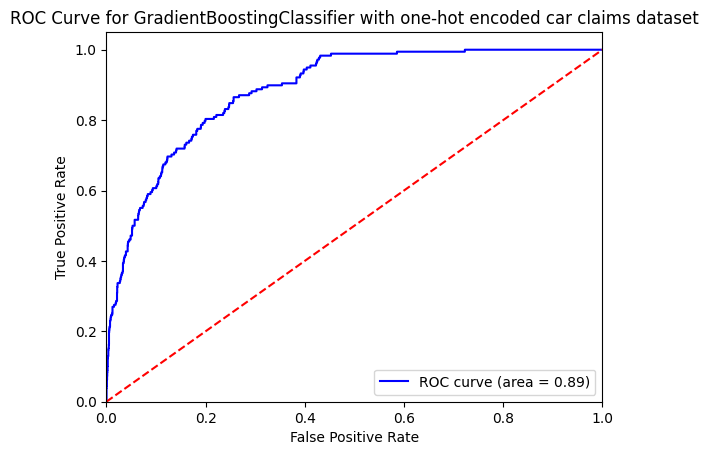

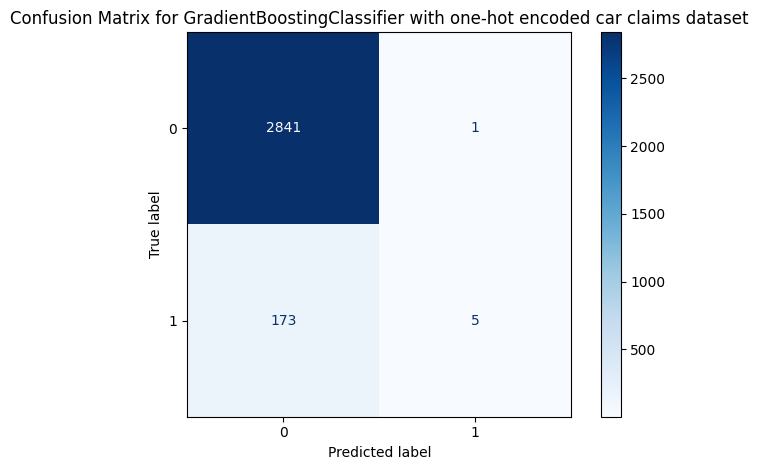

Classification Report for GradientBoostingClassifier with encoded car claims dataset:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2842
           1       1.00      0.03      0.07       178

    accuracy                           0.94      3020
   macro avg       0.97      0.52      0.52      3020
weighted avg       0.95      0.94      0.92      3020



GradientBoostingClassifier Accuracy: 0.94
GradientBoostingClassifier F1 score: 0.92
GradientBoostingClassifier Precision: 0.95
GradientBoostingClassifier Recall: 0.94
GradientBoostingClassifier ROC-AUC: 0.89


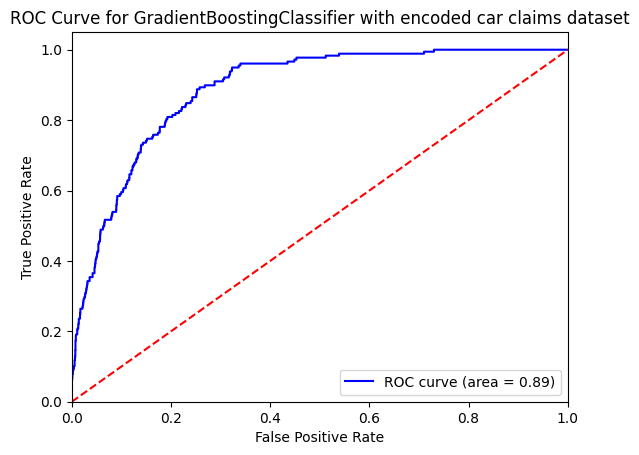

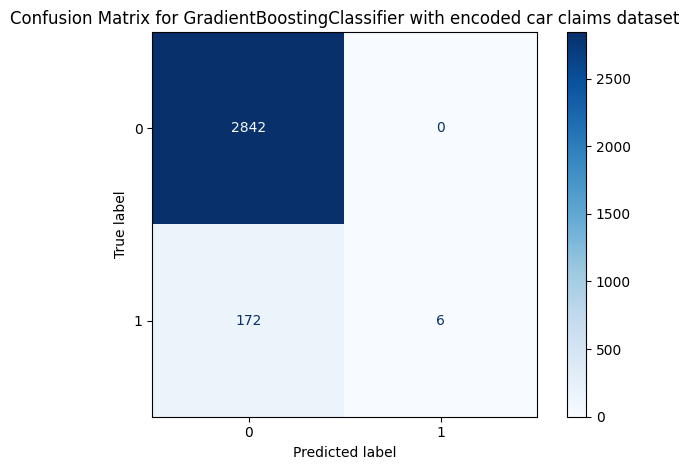

Classification Report for GradientBoostingClassifier with one-hot encoded car claims dataset:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2842
           1       0.77      0.48      0.59       178

    accuracy                           0.96      3020
   macro avg       0.87      0.73      0.78      3020
weighted avg       0.96      0.96      0.96      3020



GradientBoostingClassifier Accuracy: 0.96
GradientBoostingClassifier F1 score: 0.96
GradientBoostingClassifier Precision: 0.96
GradientBoostingClassifier Recall: 0.96
GradientBoostingClassifier ROC-AUC: 0.97


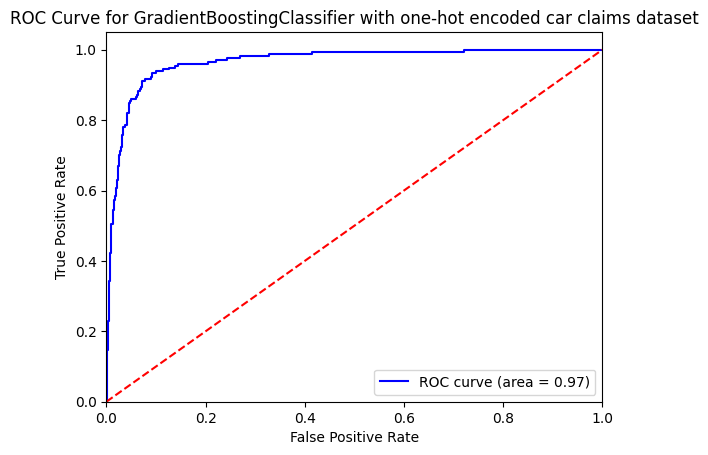

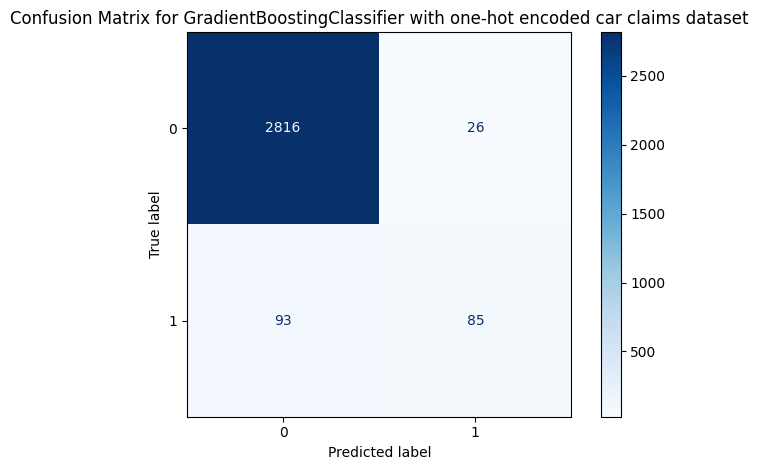

Classification Report for GradientBoostingClassifier with encoded car claims dataset:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2842
           1       0.77      0.34      0.47       178

    accuracy                           0.95      3020
   macro avg       0.86      0.67      0.72      3020
weighted avg       0.95      0.95      0.95      3020



GradientBoostingClassifier Accuracy: 0.95
GradientBoostingClassifier F1 score: 0.95
GradientBoostingClassifier Precision: 0.95
GradientBoostingClassifier Recall: 0.95
GradientBoostingClassifier ROC-AUC: 0.96


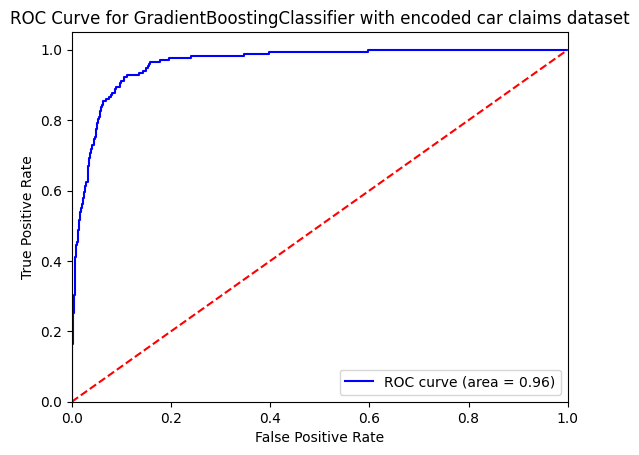

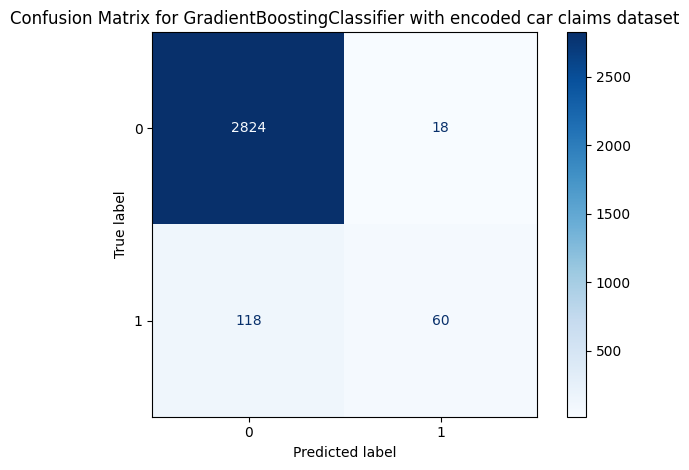

In [17]:
# One-hot encoded and Regularized
base_car_oh_model, base_car_oh_pred, base_car_oh_results = classifier_model(
    "one-hot encoded car claims dataset",
    GradientBoostingClassifier,
    X_train_car_oh_reg,
    y_train_car_oh_reg,
    X_test_car_oh_reg,
    y_test_car_oh_reg
)

# Label Encoded and Regularized
base_car_reg_model, base_car_reg_pred, base_car_reg_results = classifier_model(
    "encoded car claims dataset",
    GradientBoostingClassifier, 
    X_train_car_reg, 
    y_train_car_reg, 
    X_test_car_reg, 
    y_test_car_reg
)

grid_car_oh_model, grid_car_oh_pred, grid_car_oh_results = classifier_model(
    "one-hot encoded car claims dataset",
    GradientBoostingClassifier,
    X_train_car_oh_reg,
    y_train_car_oh_reg,
    X_test_car_oh_reg,
    y_test_car_oh_reg,
    **grid_best_params_car_oh
)

# Label Encoded and Regularized
grid_car_reg_model, grid_car_reg_pred, grid_car_reg_results = classifier_model(
    "encoded car claims dataset",
    GradientBoostingClassifier, 
    X_train_car_reg, 
    y_train_car_reg, 
    X_test_car_reg, 
    y_test_car_reg,
    **grid_best_params_car_reg
)

In [18]:
# DataFrame of the Car Claims results
df_car_results = pd.DataFrame({
    'base_oh': base_car_oh_results,
    'base_reg': base_car_reg_results,
    'grid_oh': grid_car_oh_results,
    'grid_reg': grid_car_reg_results
})

# Print the results DataFrame
print("\nCar Claims Results DataFrame:\n")
df_car_results


Car Claims Results DataFrame:



,base_oh,base_reg,grid_oh,grid_reg
data_used,one-hot encoded car claims dataset,encoded car claims dataset,one-hot encoded car claims dataset,encoded car claims dataset
model_name,GradientBoostingClassifier,GradientBoostingClassifier,GradientBoostingClassifier,GradientBoostingClassifier
model_params,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
accuracy,0.942384,0.943046,0.960596,0.954967
f1_score,0.916301,0.917263,0.956258,0.946561
precision,0.936161,0.946297,0.956109,0.948654
recall,0.942384,0.943046,0.960596,0.954967
auc_roc,0.886221,0.887624,0.965509,0.9614
